# AFV code demonstration

We demonstrate the code used in the paper *Efficient simulation of affine forward variance models*.

In [1]:
setwd("/Users/JGatheral/Documents/rFiles")

In [2]:
library(repr)

In [3]:
source("BlackFormula.R")
source("AFVsimulation.R")
source("GammaKernel.R")
source("roughHestonAdams.R")
source("roughHestonPade.R")
source("Lewis.R")

In [4]:
bl <- "royalblue"
rd <- "red2"
pk <- "hotpink1"
gr <- "green4"

### Parameters

We choose parameters similar to those found from a fit to SPX options as of May 19, 2017, the same data that was used in Roughening Heston.

In [5]:
params0 <- list(al=0.55,lam=0,eta=0.8,rho=-0.65, H=0.05,lam=0)
xi0 <- function(s){0.025+0*s} # The forward variance curve

### Simulation using the RSQE and HQE schemes

The option "all" returns a list with many variables of interest.

In [6]:
system.time(rsqe.sim <- RSQE.sim(params0, xi0)(paths=100000, steps=100, expiries=1,output="all"))

   user  system elapsed 
  6.407   2.240   8.664 

In [7]:
system.time(hqe.sim.100 <- HQE.sim(params0, xi0)(paths=100000, steps=100, expiries=1,output="all"))

   user  system elapsed 
  9.033   3.069  12.114 

In [8]:
system.time(hqe.sim.200 <- HQE.sim(params0, xi0)(paths=100000, steps=200, expiries=1,output="all"))

   user  system elapsed 
 24.593   9.345  34.129 

In [9]:
names(hqe.sim.100)

[1] "v" "x" "y" "w"

- v is terminal variance $v_T$
- x is terminal log-spot $X_T$
- y is terminal value of $Y_T = \int_0^T\,\sqrt{v_s}\,dW_s$.
- w is terminal value of quadratic variation $w_T = \int_0^T\,{v_s}\,ds$.

#### Parallelization

The code can be run in parallel with selected variables as output.

For example, here with $v_T$ as output.

In [10]:
library(foreach)
library(doParallel)

Loading required package: iterators

Loading required package: parallel



In [11]:
paths <- 1000000 # Note 1 million paths here!
steps <- 100

In [12]:
t0<-proc.time()

# Number of iterations
iters<- max(1,floor(paths/1000))

# Setup parallel backend to use all processors
(cl.num <- detectCores()) # Display number of processors on your machine
cl<-makeCluster(cl.num)
registerDoParallel(cl)

# Loop
ls <- foreach(icount(iters)) %dopar% {
        HQE.sim(params0, xi0)(paths=1000, steps=steps, expiries=1,output="v")
        }

stopCluster(cl)
    hqe.sim.v <- do.call(cbind, ls) #Bind all of the submatrices into one big matrix

print(proc.time()- t0)

[1] 16

   user  system elapsed 
  0.644   0.205  22.468 


### Figure 7.6: Histograms of $v_T$

In [13]:
options(repr.plot.width=14,repr.plot.height=7,repr.plot.res=150)

In [14]:
vv <- hqe.sim.v

In [15]:
vvg <- vv[vv > 1e-9] # Restrict sample to values greater than tiny

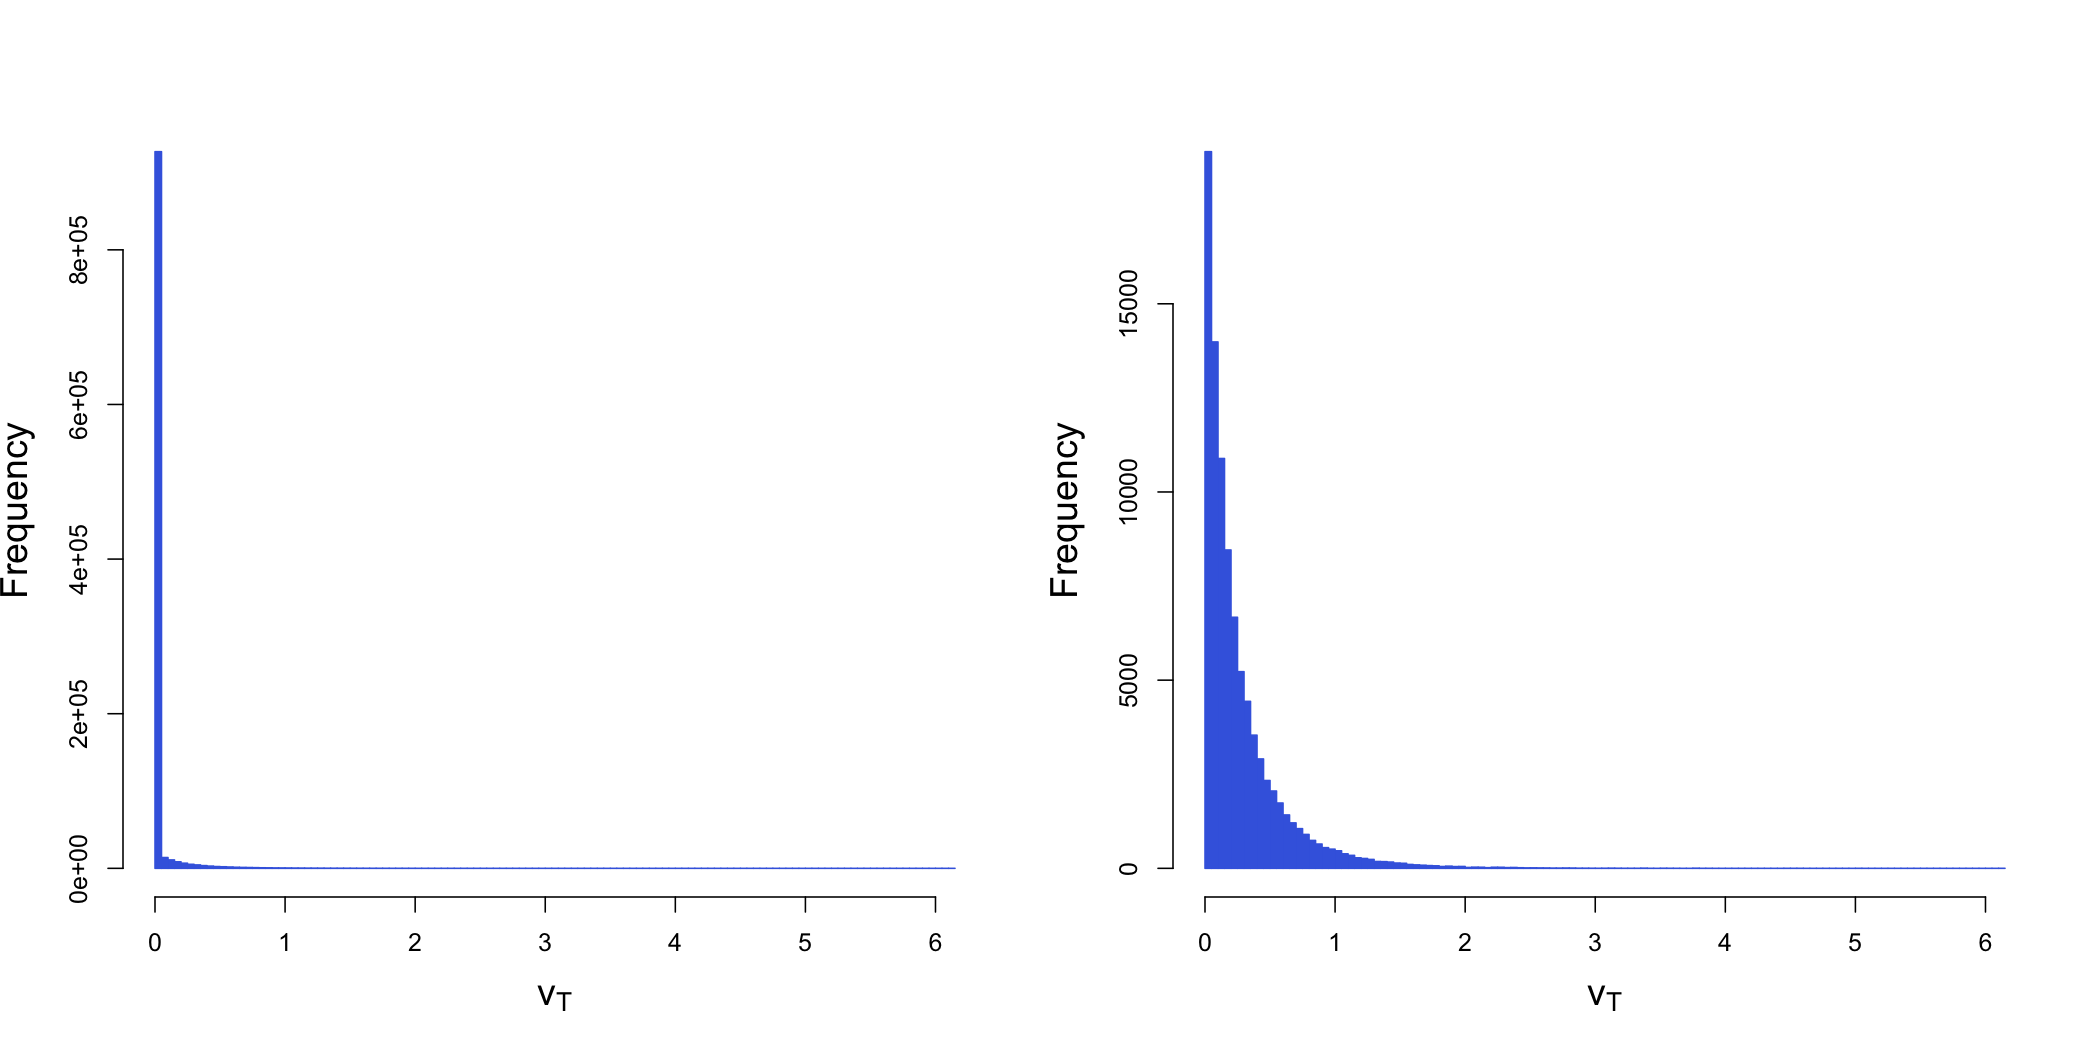

In [16]:
par(mfrow=c(1,2))
hist(vv,breaks=200,xlab=expression(v[T]),main="",col=bl, border=bl, cex.lab=1.5)
par(new=F)
hist(vvg,breaks=200,xlab=expression(v[T]),main="",col=bl,border=bl, cex.lab=1.5)
par(mfrow=c(1,1))

### Histograms of terminal stock prices

In [17]:
spots.100 <- exp(hqe.sim.100$x)
spots.200 <- exp(hqe.sim.200$x)

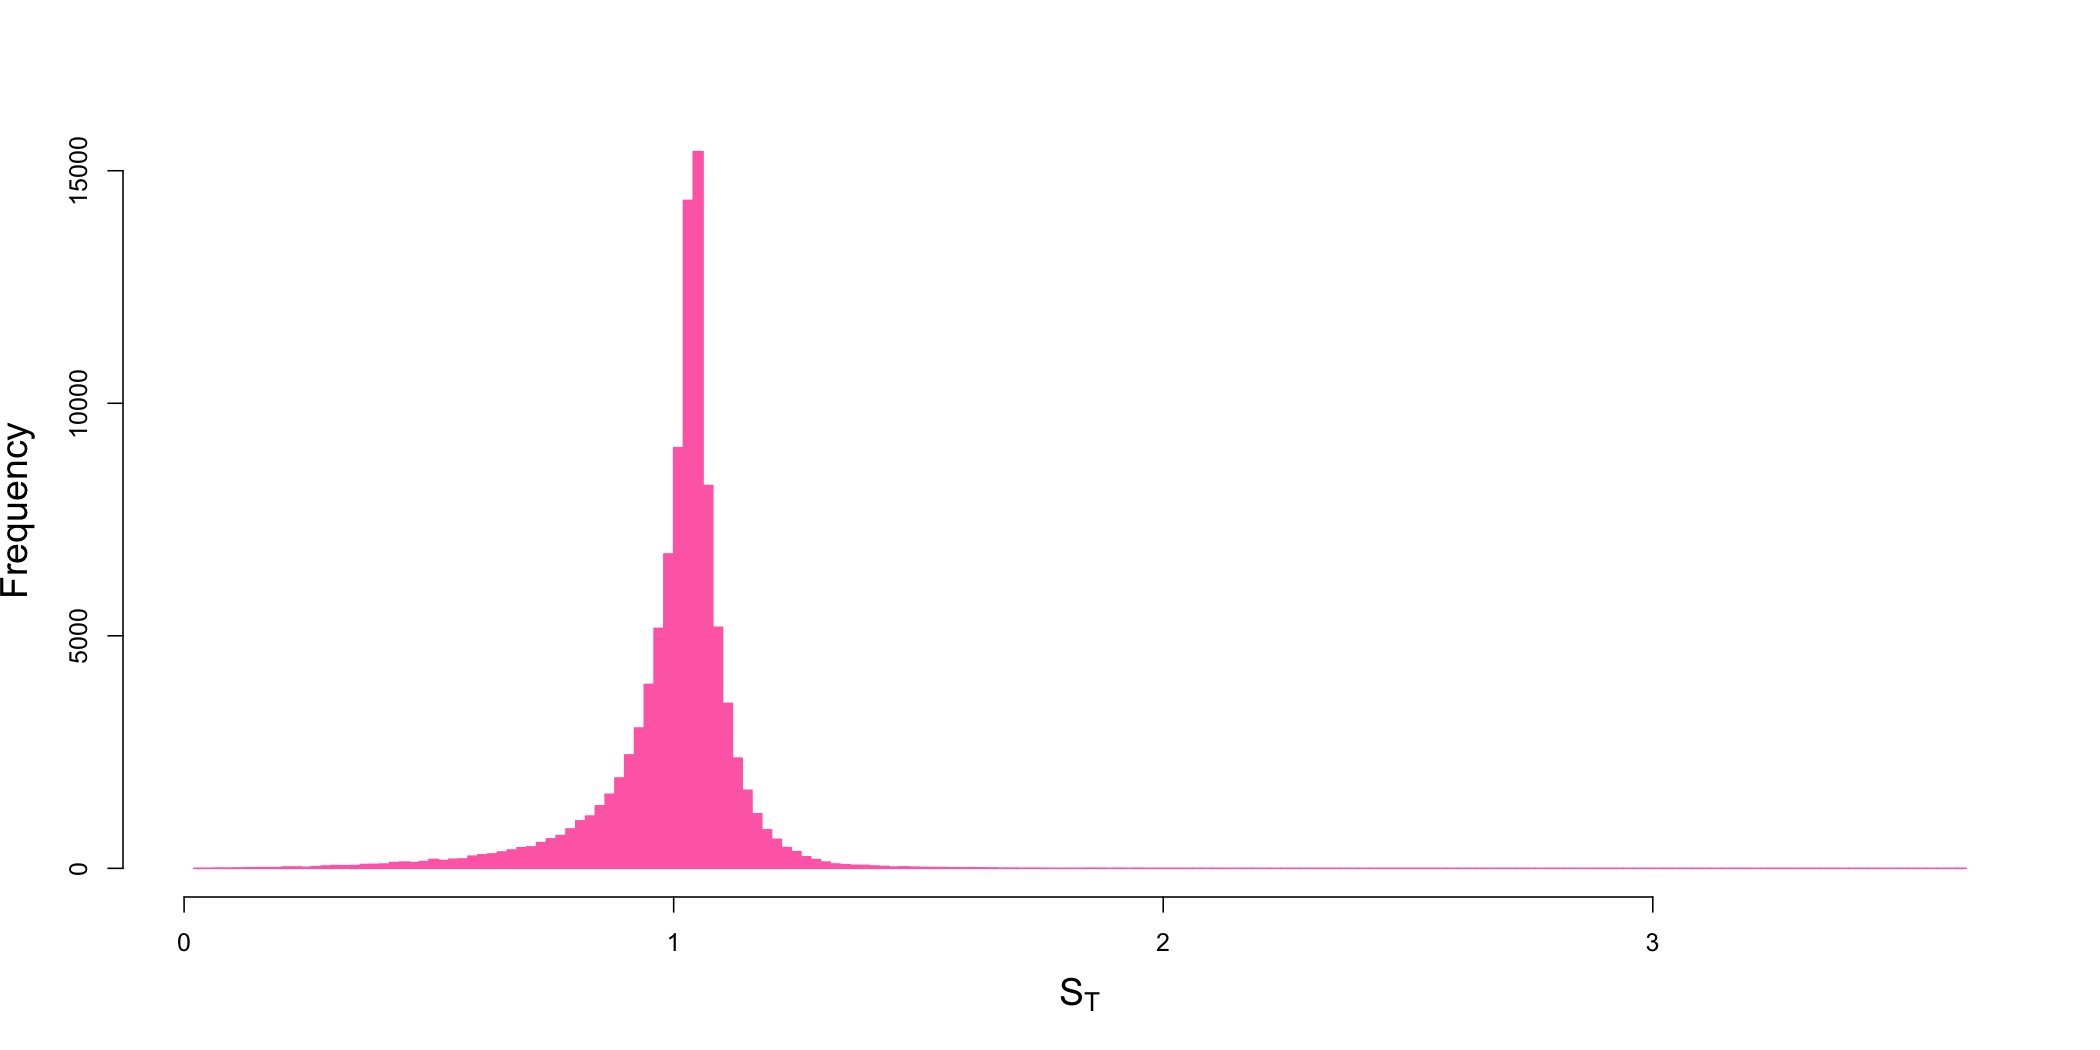

In [18]:
hist(spots.100,breaks=200,xlab=expression(S[T]),main="",col=pk, border=pk, cex.lab=1.5)

Note the fat negative tail in the return distribution.

### Draw the 1 year smile with the above parameters

In [19]:
smile.100 <- function(k){ivS(spots.100, T=1, mean(spots.100)*exp(k))}
smile.200 <- function(k){ivS(spots.200, T=1, mean(spots.200)*exp(k))}

We select a vector of log-strikes.

In [20]:
kk <- seq(-.4,.4,.01)

In [21]:
smile.HQE.100 <- smile.100(kk)
smile.HQE.200 <- smile.200(kk)

In [22]:
options(repr.plot.width=10,repr.plot.height=7,repr.plot.res=150)

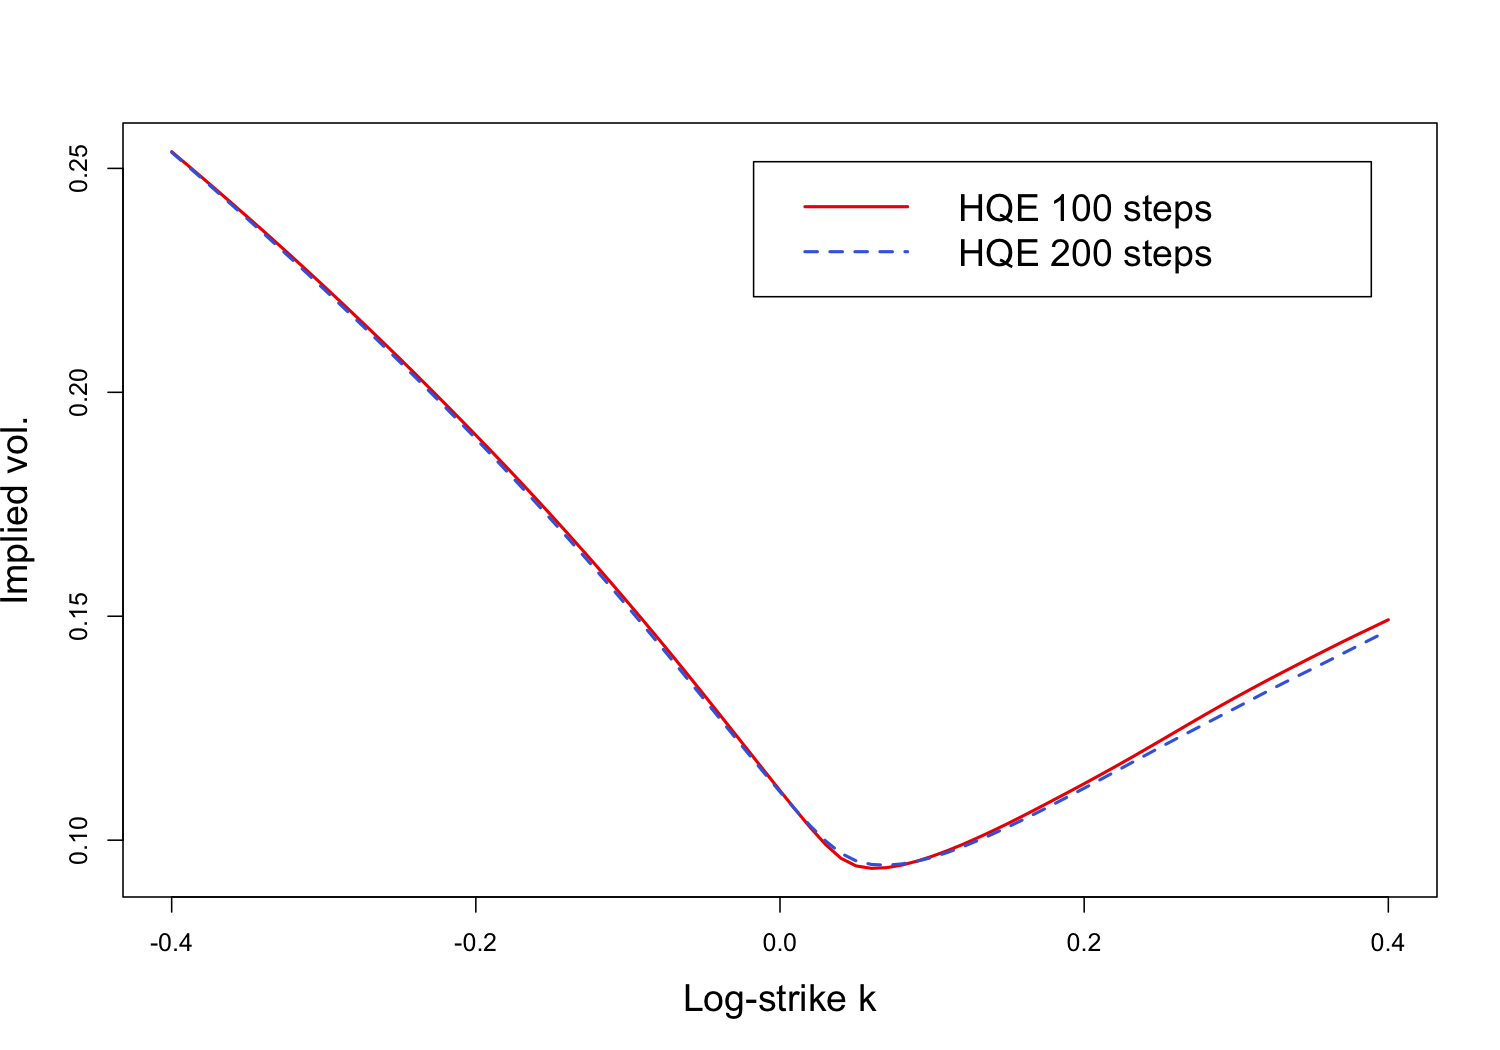

In [23]:
plot(kk,smile.HQE.100,col=rd,lwd=2,type="l",
     xlab="Log-strike k", ylab = "Implied vol.",cex.lab=1.5)
lines(kk,smile.HQE.200,col=bl,lwd=2,lty=2)
legend("topright",c("HQE 100 steps","HQE 200 steps"), cex=1.5, inset=.05, 
       lty=c(1,2),col=c(rd,bl), lwd=2)

### Richardson extrapolated smile

In [24]:
smile.HQE.Richardson <- 2*smile.200(kk)-smile.100(kk)

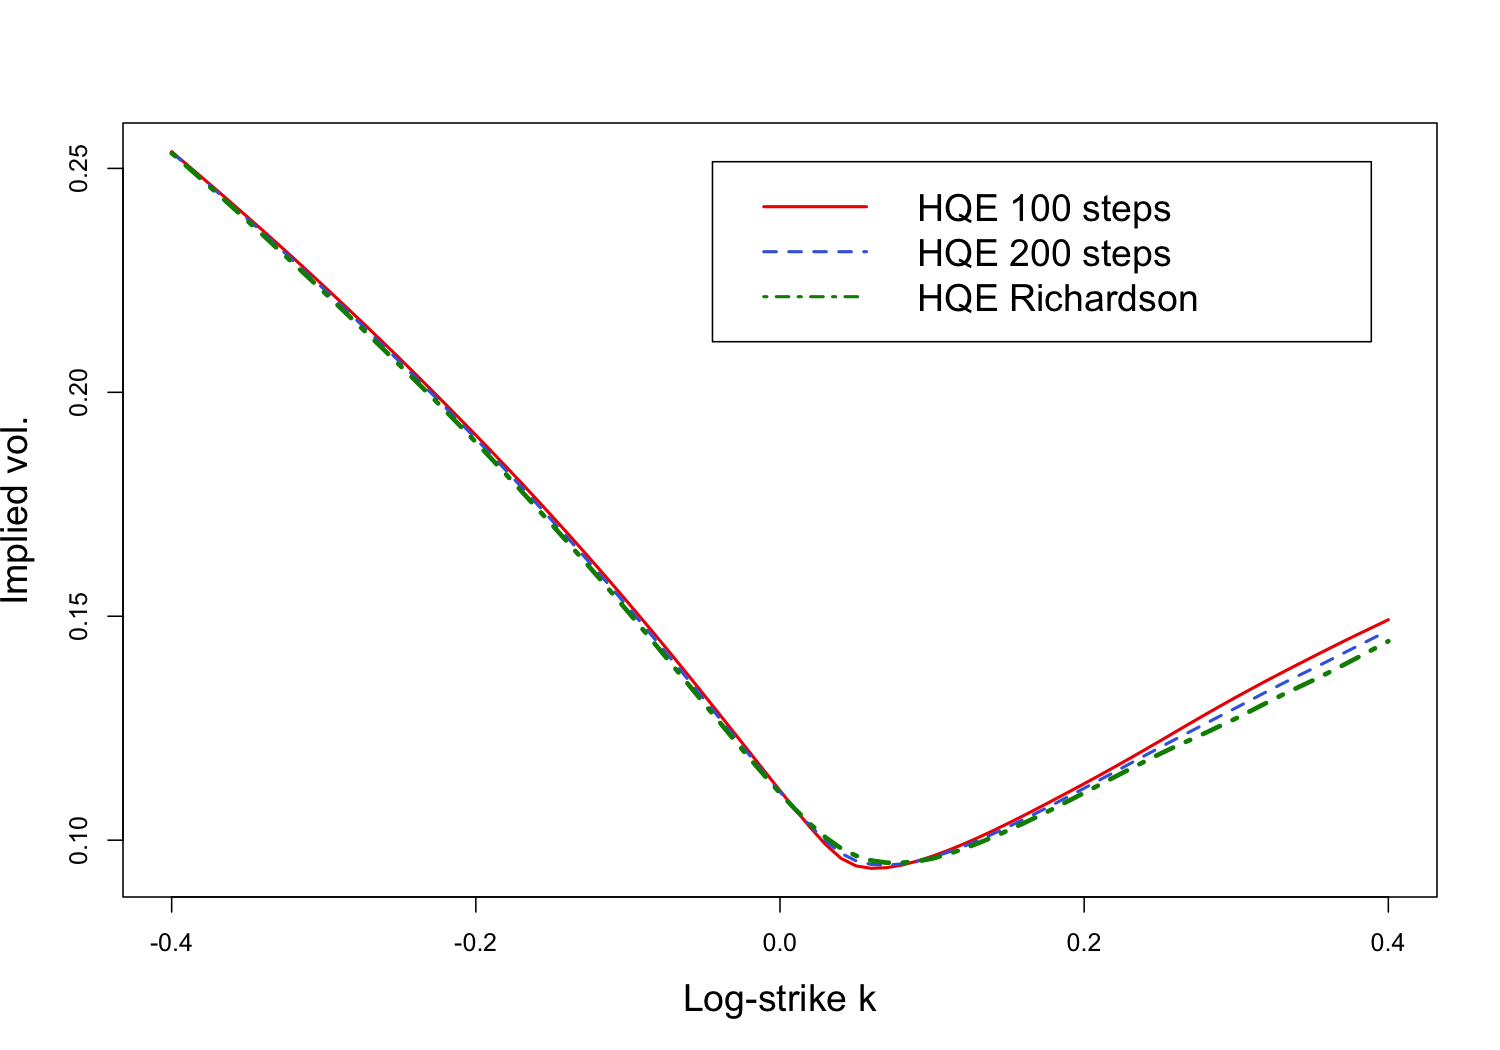

In [25]:
plot(kk,smile.HQE.100,col=rd,lwd=2,type="l",
     xlab="Log-strike k", ylab = "Implied vol.",cex.lab=1.5)
lines(kk,smile.HQE.200,col=bl,lwd=2,lty=2)
lines(kk,smile.HQE.Richardson,col=gr,lwd=3,lty=4)
legend("topright",c("HQE 100 steps","HQE 200 steps",
    "HQE Richardson"), cex=1.5, inset=.05, 
       lty=c(1,2,4),col=c(rd,bl,gr), lwd=2)

### Parameter conversion

The QE simulation and the Adams/Padé approximations use different formulations of the rough Heston model.

In the QE case,

$$
d\xi_t(u) = \eta\,\sqrt{2 H}\,(u-t)^{\alpha-1}.
$$

In the Adams/Padé case,

$$
d\xi_t(u) = \frac{\nu}{\Gamma(\alpha)}\,(u-t)^{\alpha-1}.
$$

Thus

$$
\nu = \sqrt{2 H}\, \Gamma(\alpha)\,\eta.
$$

In [26]:
(params0$nu <- params0$eta*sqrt(2*params0$al-1)*gamma(params0$al))

[1] 0.4088507

### Comparison with Adams smile

Note that the Adams smile takes time to compute.

In [27]:
system.time(vol.Adams.kk.1y.200 <-  impliedVolRoughHeston(params0, xi0, nSteps=200)(kk,1))

   user  system elapsed 
106.990   6.931 114.075 

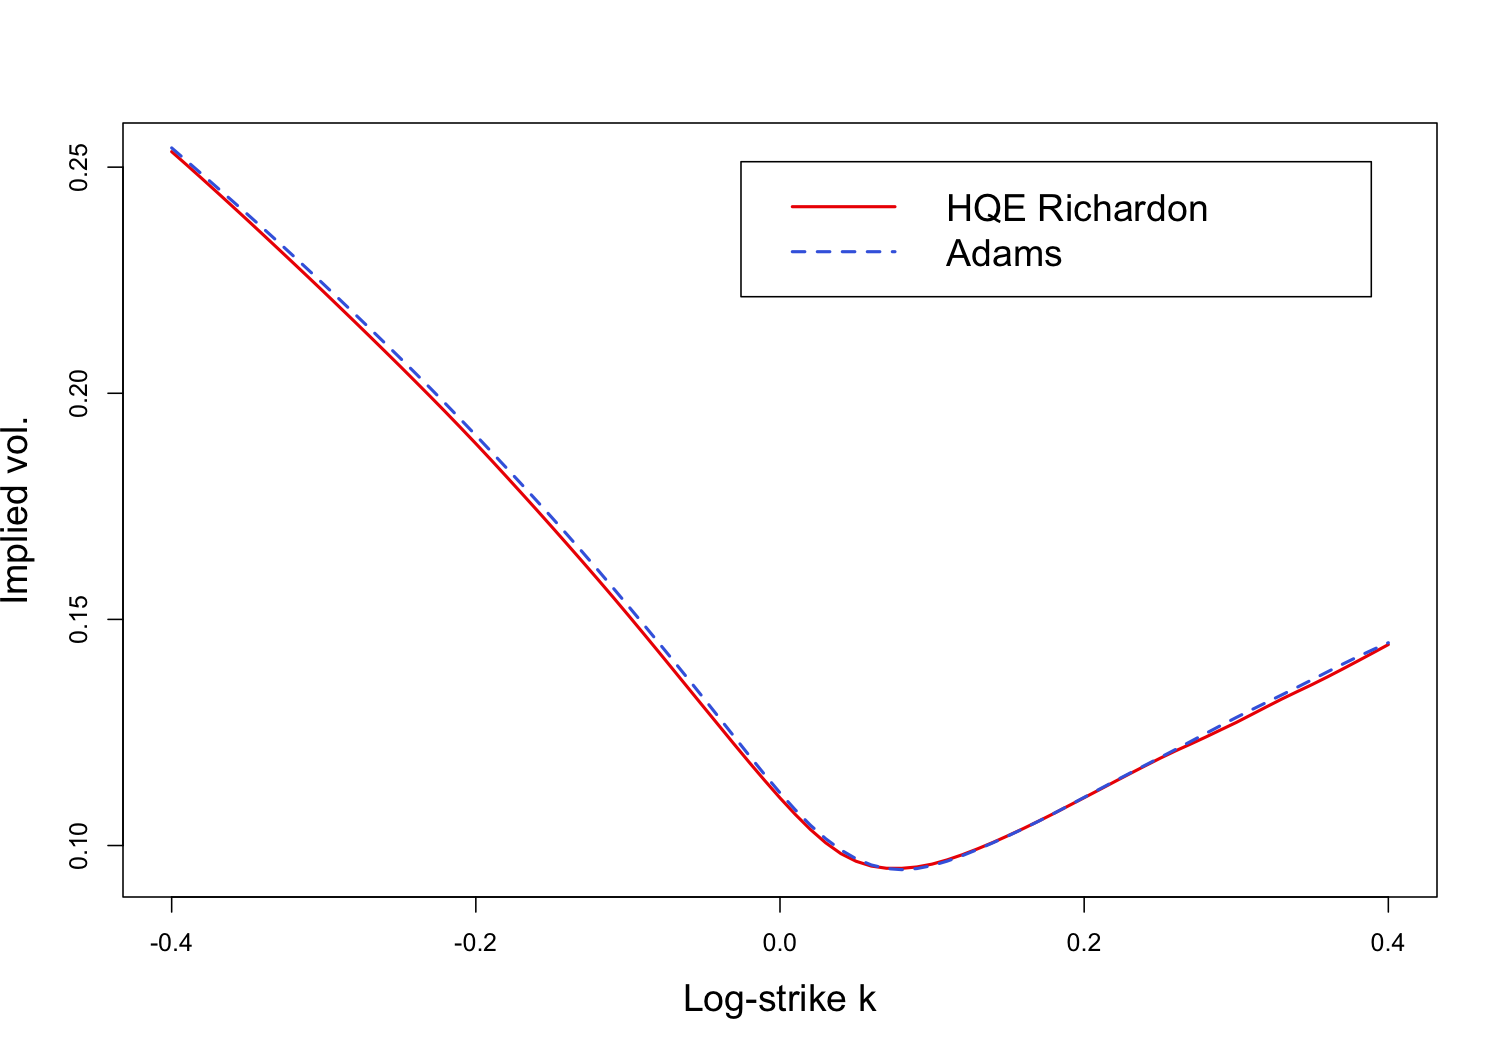

In [28]:
plot(kk,smile.HQE.Richardson,col=rd,lwd=2,type="l",
     xlab="Log-strike k", ylab = "Implied vol.",cex.lab=1.5)
lines(kk,vol.Adams.kk.1y.200,col=bl,lwd=2,lty=2)
legend("topright",c("HQE Richardon","Adams"), cex=1.5, inset=.05, 
       lty=c(1,2),col=c(rd,bl), lwd=2)

### Padé approximation

In [29]:
phi.Pade <- phiRoughHestonDhApprox(params0, xi0, dh.approx= d.h.Pade33, n=500)

In [30]:
system.time(vol.Pade.kk.1y <-  impvol.phi(phi.Pade)(kk,1))

   user  system elapsed 
  3.113   0.225   3.338 

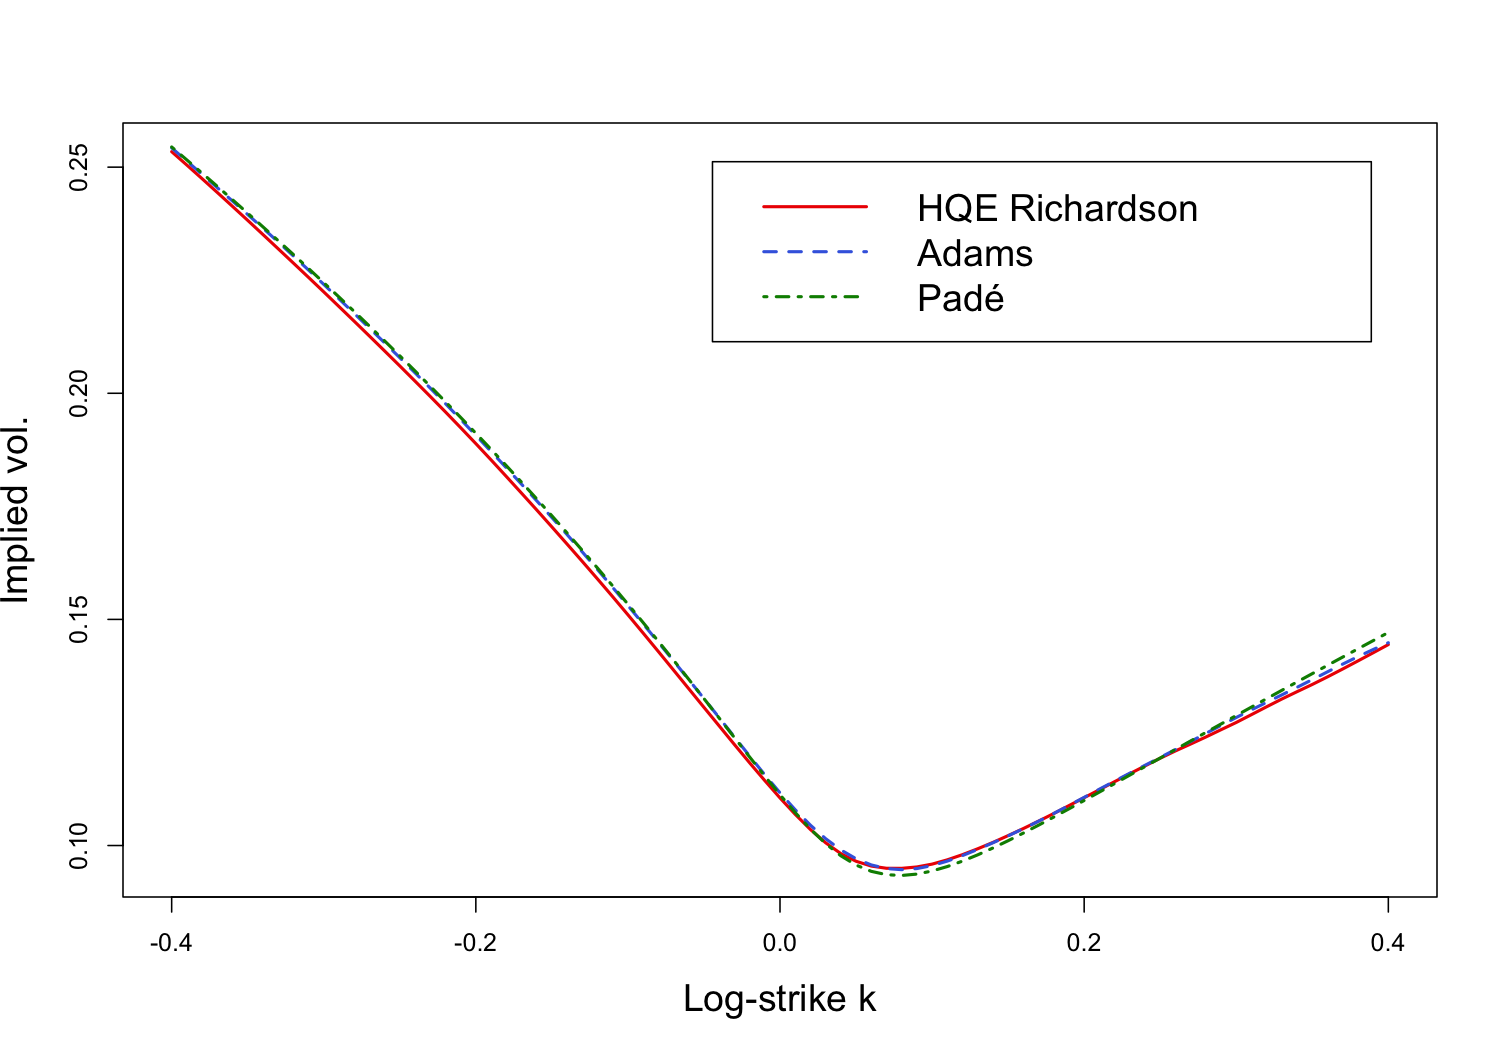

In [31]:
plot(kk,smile.HQE.Richardson,col=rd,lwd=2,type="l",
     xlab="Log-strike k", ylab = "Implied vol.",cex.lab=1.5)
lines(kk,vol.Adams.kk.1y.200,col=bl,lwd=2,lty=2)
lines(kk,vol.Pade.kk.1y,col=gr,lwd=2,lty=4)
legend("topright",c("HQE Richardson","Adams","Padé"), cex=1.5, inset=.05, 
       lty=c(1,2,4),col=c(rd,bl,gr), lwd=2)

To get reliable agreement between these smiles, a greater number of paths (such as 1 million) is needed.  Alternatively (and better), variance reduction can be implemented.